# **Predicting Playoff Potential: Key Factors Behind NBA Playoff Teams**

## Team

- **Collin Kneiss**  - **Point of Contact**
- **Ankit Waikar** 
- **Odbileg Erdenebileg** 


## Overview

We are aiming to determine the key factors that distinguish NBA teams that make the playoffs from those that do not. By analyzing comprehensive team statistics over several decades, we seek to predict playoff participation and identify the most significant contributors to a team's success.

Our approach goes beyond traditional methods by incorporating additional factors such as superstar talent effects, coaching excellence impact, and attendance influence. By including these variables, we believe we can capture nuanced aspects of team performance that are often overlooked, leading to more accurate predictions of playoff potential.

Our primary stakeholders are NBA coaches, analysts, fans, and team front offices. Successful identification of key success factors will enable coaches and analysts to develop targeted improvement strategies, help fans better understand team performance metrics, and assist front offices in making informed decisions regarding player acquisitions and resource allocation.

*Since our last submission, we have narrowed our focus to predicting playoff teams rather than champions to provide more specific analysis and actionable insights.*

## Data

Our dataset is sourced from [Basketball Reference](https://www.basketball-reference.com/), a reputable and widely-used resource for NBA statistics. We collected data on team per-game statistics, opponent per-game statistics, and advanced metrics for NBA teams from 1980 to 2021, resulting in a dataset with 1,254 rows and 78 columns.

To validate the credibility of the dataset, we performed the following steps:

- **Cross-Verification**: Random samples of the data were cross-referenced with official NBA statistics and other reliable sports analytics websites to ensure accuracy.
- **Source Reputation**: Acknowledged that Basketball Reference is a trusted source among sports analysts, researchers, and enthusiasts, adding to the dataset's reliability.

### Exploratory Data Analysis

First, we examined the distributions of the per-game statistics to identify any patterns or anomalies.

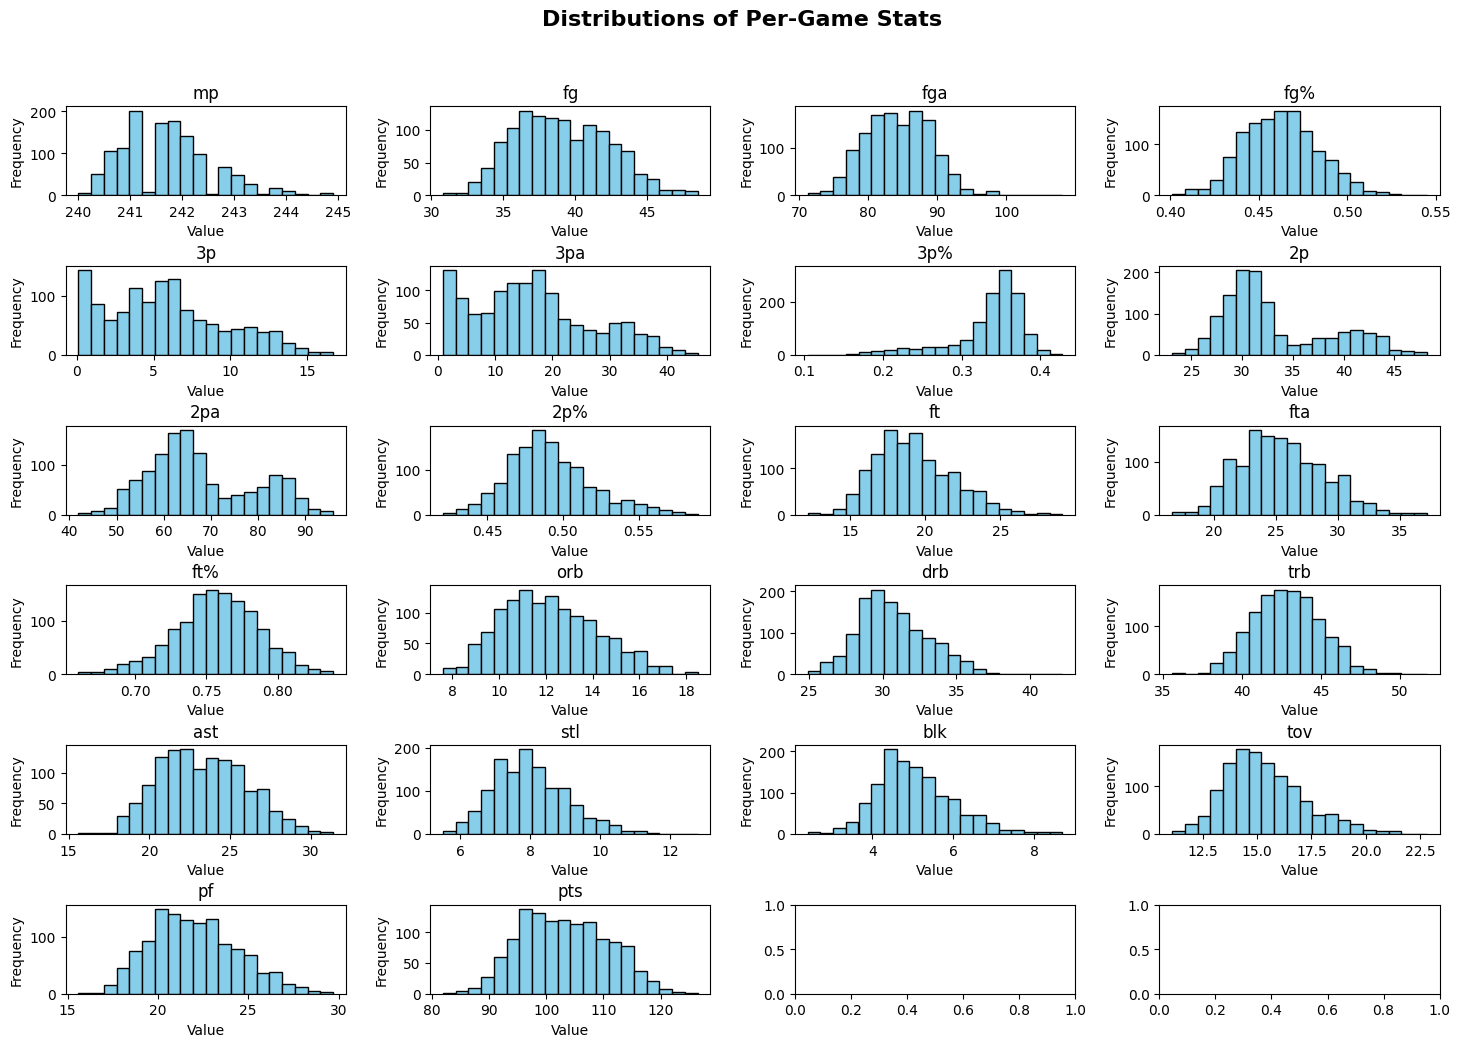

In [40]:

# Plotting distributions of per-game statistics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Importing our data
nba = pd.read_csv("/workspaces/student-group-project-the-a-team/checkpoint2/IST707_NBA_Data.csv")
nba.head()

import janitor

#Cleaning data frame
nba = pd.DataFrame(nba) 
nba = nba.clean_names()

#print(nba.columns)


per_game_stats = nba.loc[:, 'mp':'pts']

# Setting up subplots
num_vars = per_game_stats.shape[1]
num_cols = 4
num_rows = (num_vars // num_cols) + (num_vars % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.tight_layout(pad=3.0)
fig.suptitle("Distributions of Per-Game Stats", fontsize=16, fontweight='bold', y=1.05)
axes = axes.flatten()

# Plotting histograms
for i, column in enumerate(per_game_stats.columns):
    axes[i].hist(per_game_stats[column].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.show()



**From the distributions, we observed that most variables exhibit symmetric or near-symmetric distributions with long tails. Notably, field goal attempts and three-point field goals do not follow this pattern, which aligns with the evolution of the game where three-point shots have become more prevalent over time.**

We conducted similar analyses on opponent per-game statistics and advanced statistics, noting consistent patterns that suggest these variables could be significant in predicting playoff success.

Distribution of Playoff Participation
We also examined the distribution of our target variable, playoff participation.

/tmp/ipykernel_5527/3688154672.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=playoff_counts.index, y=playoff_counts.values, palette='viridis')


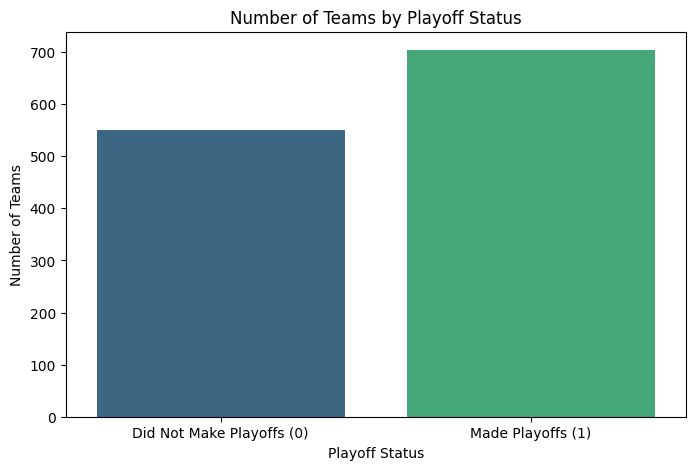

In [41]:

# Plotting the distribution of playoff participation
playoff_counts = nba['playoff'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=playoff_counts.index, y=playoff_counts.values, palette='viridis')
plt.xticks([0, 1], ['Did Not Make Playoffs (0)', 'Made Playoffs (1)'])
plt.xlabel('Playoff Status')
plt.ylabel('Number of Teams')
plt.title('Number of Teams by Playoff Status')
plt.show()


The plot shows that **more teams made the playoffs** than did not, which is expected since, in the NBA, **16 out of 30** teams make the playoffs each year.

### Preprocessing
**Data Cleaning**

We performed several preprocessing steps to prepare the data for modeling:

- **Column Name Cleaning**: Used the pyjanitor package to standardize column names for consistency and ease of use.

In [42]:
import janitor
#nba = nba.clean_names()

- **Dropping Irrelevant Columns**: Removed columns that do not contribute to the analysis, such as rankings, game counts (since all teams play the same number of games), arena names, and raw attendance figures.

In [43]:
%%capture

columns_to_drop = ['rk_x', 'g', 'opponent_rk', 'opponent_g', 'rk_y', 'arena', 'attend_']
nba.drop(columns=columns_to_drop, inplace=True)



- **Handling Missing Values**: Identified that the attend_g (attendance per game) column had missing values. We manually filled these based on historical attendance records.

In [44]:
# Manually updating missing attendance per game values
attendance_data = {
    ('Seattle SuperSonics', 1980): 21725,
    # ... other teams and years
}
for (team, year), attendance in attendance_data.items():
    nba.loc[(nba['team'] == team) & (nba['year'] == year), 'attend_g'] = attendance


We considered excluding the **2020-2021 season** due to anomalies caused by the COVID-19 pandemic, which **affected attendance and game counts.**

### Modeling
**Initial Linear Regression**

We began with an initial linear regression model to understand the relationships between variables.

In [ ]:
# Preparing data for linear regression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = nba.select_dtypes(include=['float64', 'int64']).drop(columns=['playoff'])
y = nba['playoff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adding constant term
X_train_with_const = sm.add_constant(X_train)

# Fitting the model
model = sm.OLS(y_train, X_train_with_const)
results = model.fit()
print(results.summary())


The model yielded an adjusted **R-squared value of 0.648**, indicating that approximately 65% of the variance in playoff participation is explained by the model. However, **given the binary nature of the target variable**, we recognized the need to switch to logistic regression.

**Multicollinearity Assessment**

Before proceeding with logistic regression, we assessed multicollinearity using Variance Inflation Factor (VIF) scores.

In [ ]:
# Calculating VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)


The VIF scores revealed **extremely high values for many variables**, indicating significant multicollinearity. This multicollinearity **can cause instability in regression coefficients** and affect the model's predictive power.

**Attempted Logistic Regression**

We attempted to fit a logistic regression model but encountered issues due to multicollinearity.

In [ ]:
# Logistic Regression
logit_model = sm.Logit(y_train, X_train_with_const)
logit_results = logit_model.fit()
print(logit_results.summary())


**The model failed to converge**, and an error was raised due to a singular matrix, confirming the need to address multicollinearity before proceeding.

### **Problems & Challenges**
- **Multicollinearity**: High VIF scores indicate multicollinearity among predictor variables, causing issues with model convergence and coefficient instability.
- **Data Complexity**: The large number of variables increases the complexity of the model, making it difficult to interpret and potentially leading to overfitting.
- **Seasonal Anomalies**: The 2020-2021 season presents anomalies due to the COVID-19 pandemic, affecting attendance and game counts.

### **Action Plan**
- **Feature Selection**: Perform feature selection techniques, such as removing variables with high VIF scores and using principal component analysis (PCA) to reduce dimensionality.
- **Data Exclusion**: Consider excluding the anomalous 2020-2021 season to maintain data consistency.
- **Model Refinement**: After addressing multicollinearity, retry logistic regression and explore other classification models like Random Forests.

### **Next Steps**
 **Feature Engineering and Selection**
- Remove variables with high multicollinearity.
- Implement PCA to reduce dimensionality.
- Create new features that may capture important aspects of team performance.

**Modeling**
- Fit a logistic regression model after addressing multicollinearity.
- Experiment with other classification algorithms (e.g., Random Forests, SVM).
- Perform hyperparameter tuning to optimize model performance.

**Validation and Evaluation**
- Evaluate models using appropriate metrics (e.g., accuracy, F1-score, ROC-AUC).
- Use cross-validation to ensure model robustness.

**Finalize Report and Presentation**
- Prepare the final report detailing methods, findings, and insights.
- Develop a presentation to communicate results effectively.
